<font size="5">**CS 178 Final Project**</font>

*Import Statements*

In [76]:
import requests           
from io import StringIO

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import zero_one_loss as J01
import numpy as np
feature_list = ["age", "workclass", "fnlwgt", "education", "education-num", 'marital-status', 'occupation', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per=week', 'native-country']


In [170]:
# getting training data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

with requests.get(url) as link:
    datafile = StringIO(link.text)
    
    adults_X = []
    adults_y = []
    for line in datafile:
        split_line = line[:-1].split(', ')
        if len(split_line) == 15:
            adults_X.append([x if x != '?' else np.nan for x in split_line[:-1]])
            adults_y.append([split_line[-1]])

    # Since not all of the inputs are numbers (there is categorical data), we need to use
    # an ordinal encoder which will translate these into integers
    ord_enc = OrdinalEncoder()
    # we are going to use the encoded_missing_value parameter to encode missing values as well,
    # this sets any missing values (?) to -1
    adults_X = ord_enc.set_params(encoded_missing_value=-1).fit_transform(adults_X)
    
    label_enc = LabelEncoder()
    adults_y = label_enc.fit_transform(adults_y)

In [163]:
# getting test data
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

with requests.get(test_url) as link:
    datafile = StringIO(link.text)
    
    adults_test_X = []
    adults_test_y = []
    for line in datafile:
        split_line = line[:-1].split(', ')
        if len(split_line) == 15:
            adults_test_X.append([x if x != '?' else np.nan for x in split_line[:-1]])
            adults_test_y.append([split_line[-1]])

    # Since not all of the inputs are numbers (there is categorical data), we need to use
    # an ordinal encoder which will translate these into integers
    ord_enc = OrdinalEncoder()
    # we are going to use the encoded_missing_value parameter to encode missing values as well,
    # this sets any missing values (?) to -1
    adults_test_X = ord_enc.set_params(encoded_missing_value=-1).fit_transform(adults_test_X)
    
    label_enc = LabelEncoder()
    adults_test_y = label_enc.fit_transform(adults_test_y)

In [171]:
adults_X = np.asarray(adults_X)
adults_y = np.asarray(adults_y)
adults_test_X = np.asarray(adults_test_X)
adults_test_y = np.asarray(adults_test_y)

In [177]:
# without adjusting any default parameters of the random forest classifier
# 100 trees, gini, max_depth = None, min_samples_split =2, min_samples_leaf = 1, bootstrap=true, max_features=sqrt
RFC = RandomForestClassifier(random_state=1234).fit(adults_X, adults_y)
adults_y_hat = RFC.predict(adults_X)
adults_test_y_hat = RFC.predict (adults_test_X)

print(f"Training Error: {J01(adults_y_hat, adults_y)}")
print(f"Testing Error: {J01(adults_test_y_hat, adults_test_y)}")

# a lot of overfitting going on :'(

Training Error: 6.142317496393712e-05
Testing Error: 0.1550887537620539


In [110]:
# change to entropy
RFC = RandomForestClassifier(random_state=1234, criterion="entropy").fit(adults_X, adults_y)
adults_y_hat = RFC.predict(adults_X)
adults_test_y_hat = RFC.predict (adults_test_X)

print(f"Training Error: {J01(adults_y_hat, adults_y)}")
print(f"Testing Error: {J01(adults_test_y_hat, adults_test_y)}")

#slightly better

Training Error: 0.00012284634992787424
Testing Error: 0.15269332350592713


In [178]:
RFC = RandomForestClassifier(random_state=1234, criterion="entropy").fit(reduced_adults_X, reduced_adults_y)
adults_y_hat = RFC.predict(adults_X)
adults_test_y_hat = RFC.predict (adults_test_X)

print(f"Training Error: {J01(adults_y_hat, reduced_adults_y)}")
print(f"Testing Error: {J01(adults_test_y_hat, adults_test_y)}")

Training Error: 3.732736095563016e-05
Testing Error: 0.15742276272956202


In [116]:
for split, leaf, training_error, test_error in table:
    print(f"Min Samples split: {split:3}, Min Sample Leaf: {leaf:2}, Training Error: {training_error:.4}, Test Error: {test_error:.4}")

Min Samples split:   5, Min Sample Leaf:  2, Training Error: 0.06311, Test Error: 0.1468
Min Samples split:   5, Min Sample Leaf:  3, Training Error: 0.08412, Test Error: 0.1486
Min Samples split:  10, Min Sample Leaf:  2, Training Error: 0.0801, Test Error: 0.1473
Min Samples split:  10, Min Sample Leaf:  3, Training Error: 0.0918, Test Error: 0.1479
Min Samples split:  10, Min Sample Leaf:  5, Training Error: 0.1068, Test Error: 0.1472
Min Samples split:  25, Min Sample Leaf:  2, Training Error: 0.1006, Test Error: 0.1462
Min Samples split:  25, Min Sample Leaf:  3, Training Error: 0.1058, Test Error: 0.1477
Min Samples split:  25, Min Sample Leaf:  5, Training Error: 0.1159, Test Error: 0.1469
Min Samples split:  25, Min Sample Leaf: 10, Training Error: 0.1261, Test Error: 0.1473
Min Samples split:  50, Min Sample Leaf:  2, Training Error: 0.1141, Test Error: 0.1463
Min Samples split:  50, Min Sample Leaf:  3, Training Error: 0.1185, Test Error: 0.1469
Min Samples split:  50, Min Sa

In [55]:
# min_sample_split: 25 with min_sample_leaf 2 seems to have the lowest average testing error

Text(0.5, 0, 'Max Depth')

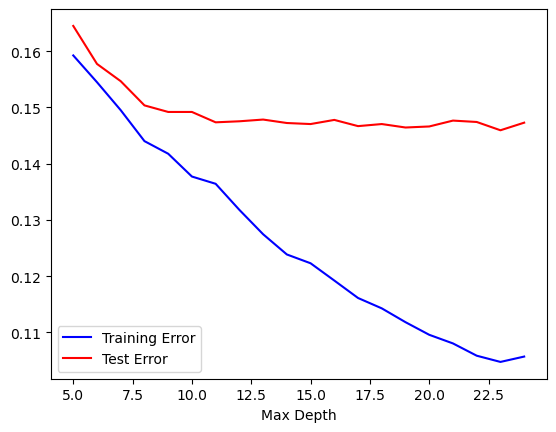

In [139]:
# try adjusting max_depth

training_error = []
test_error = []

for i in range(5,25):
    RFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_depth=i,min_samples_split=25, min_samples_leaf=2).fit(adults_X, adults_y)

    adults_y_hat = RFC.predict(adults_X)
    adults_test_y_hat = RFC.predict (adults_test_X)
    training_error.append(J01(adults_y_hat, adults_y))
    test_error.append(J01(adults_test_y_hat, adults_test_y))
    
plt.plot([i for i in range(5,25)], training_error, color='blue')
plt.plot([i for i in range(5,25)], test_error, color="red")
plt.legend(["Training Error", "Test Error"], loc='lower left')
plt.xlabel("Max Depth")



In [141]:
for depth, error in zip([i for i in range(5,25)], test_error):
    print(f"Depth: {depth:2}, error: {error:.4}")
    # Test error seemed to be around the same after depth 10 

Depth:  5, error: 0.1497
Depth:  6, error: 0.1471
Depth:  7, error: 0.1464
Depth:  8, error: 0.1467
Depth:  9, error: 0.1473
Depth: 10, error: 0.1457
Depth: 11, error: 0.1481
Depth: 12, error: 0.1487
Depth: 13, error: 0.1488
Depth: 14, error: 0.1505
Depth: 15, error: 0.1494
Depth: 16, error: 0.1499
Depth: 17, error: 0.1509


Text(0.5, 0, 'Max Features')

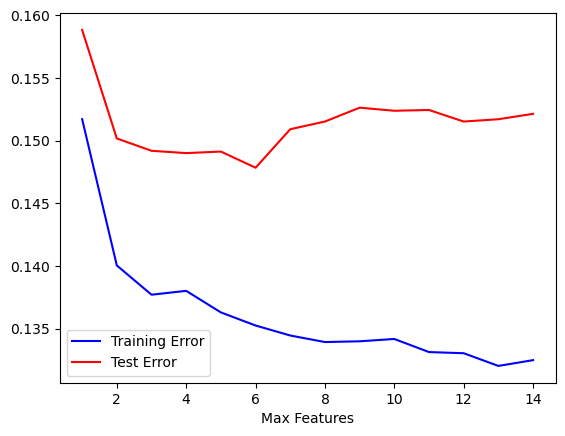

In [142]:
# change the number of features being used to consider where to split, default is square root of number of features

training_error = []
test_error = []

for i in range(1,15):
    RFC = RandomForestClassifier(random_state=1234, criterion="entropy", max_depth=10,max_features=i,min_samples_split=25,min_samples_leaf=2).fit(adults_X, adults_y)

    adults_y_hat = RFC.predict(adults_X)
    adults_test_y_hat = RFC.predict (adults_test_X)
    training_error.append(J01(adults_y_hat, adults_y))
    test_error.append(J01(adults_test_y_hat, adults_test_y))
    
plt.plot([i for i in range(1,15)], training_error, color='blue')
plt.plot([i for i in range(1,15)], test_error, color="red")
plt.legend(["Training Error", "Test Error"], loc='lower left')
plt.xlabel("Max Features")


In [143]:
for max_feature, error in zip([i for i in range(1,15)], test_error):
    print(f"Max Feature: {max_feature:2}, Test Error: {error:.4}")
    # not any better

Max Feature:  1, Test Error: 0.1588
Max Feature:  2, Test Error: 0.1502
Max Feature:  3, Test Error: 0.1492
Max Feature:  4, Test Error: 0.149
Max Feature:  5, Test Error: 0.1491
Max Feature:  6, Test Error: 0.1478
Max Feature:  7, Test Error: 0.1509
Max Feature:  8, Test Error: 0.1515
Max Feature:  9, Test Error: 0.1526
Max Feature: 10, Test Error: 0.1524
Max Feature: 11, Test Error: 0.1524
Max Feature: 12, Test Error: 0.1515
Max Feature: 13, Test Error: 0.1517
Max Feature: 14, Test Error: 0.1521


## Feature Reduction

In [179]:
#source code: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
RFC = RandomForestClassifier(random_state=1234, criterion="entropy", max_depth=19,max_features=12,min_samples_split=25,min_samples_leaf=2).fit(adults_X, adults_y)

importances = list(RFC.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: -x[1])

for feature, importance in feature_importances:
    print(f"{feature:20}: {importance}")

occupation          : 0.26
education-num       : 0.14
sex                 : 0.13
age                 : 0.11
fnlwgt              : 0.09
capital-loss        : 0.07
marital-status      : 0.06
occupation          : 0.04
capital-gain        : 0.04
workclass           : 0.02
education           : 0.01
relationship        : 0.01
hours-per=week      : 0.01
race                : 0.0


In [180]:
# chose to use first 9 features because feature importances of those add up to 95%
important_feature_names = [feature[0] for feature in feature_importances[0:9]]

important_indices = [feature_list.index(feature) for feature in important_feature_names]
reduced_adults_X = adults_X[:, important_indices]
reduced_adults_test_X = adults_test_X[:, important_indices]

In [190]:
RFC = RandomForestClassifier(random_state=1234, criterion="entropy")
RFC.fit(reduced_adults_X, adults_y)
adults_y_hat = RFC.predict(reduced_adults_X)
adults_test_y_hat = RFC.predict (reduced_adults_test_X)
print(f"Training Error: {J01(adults_y_hat, adults_y)}")
print(f"Testing Error: {J01(adults_test_y_hat, adults_test_y)}")

Training Error: 0.00021498111237372441
Testing Error: 0.1603709845832566


In [191]:
# first try increasing the threshold in which splits can occur
min_samples_split = [5, 10, 25, 50, 100]
min_samples_leaf = [2, 3, 5, 10]
table = []

for split in min_samples_split:
    for leaf in min_samples_leaf:
        if leaf < split:
            training_errors = []
            testing_errors = []
            for _ in range(10): # sample 10 random forests for each combination of leaves and split thresholds
                RFC = RandomForestClassifier(random_state=1234,criterion="entropy", min_samples_split=split, min_samples_leaf=leaf)
                RFC.fit(reduced_adults_X, adults_y)
                adults_y_hat = RFC.predict(reduced_adults_X)
                adults_test_y_hat = RFC.predict (reduced_adults_test_X)
                training_errors.append(J01(adults_y_hat, adults_y))
                testing_errors.append(J01(adults_test_y_hat, adults_test_y))
            row = [split, leaf]
            row.append(sum(training_errors)/ len(training_errors))
            row.append(sum(testing_errors)/ len(testing_errors))
            table.append(row)

for split, leaf, training_error, test_error in table:
    print(f"Min Samples split: {split:3}, Min Sample Leaf: {leaf:2}, Training Error: {training_error:.4}, Test Error: {test_error:.4}")
    
# slightly lower! below 14.5 error now

Min Samples split:   5, Min Sample Leaf:  2, Training Error: 0.05264, Test Error: 0.1539
Min Samples split:   5, Min Sample Leaf:  3, Training Error: 0.07552, Test Error: 0.1504
Min Samples split:  10, Min Sample Leaf:  2, Training Error: 0.07417, Test Error: 0.1499
Min Samples split:  10, Min Sample Leaf:  3, Training Error: 0.08581, Test Error: 0.1492
Min Samples split:  10, Min Sample Leaf:  5, Training Error: 0.09941, Test Error: 0.1486
Min Samples split:  25, Min Sample Leaf:  2, Training Error: 0.1012, Test Error: 0.148
Min Samples split:  25, Min Sample Leaf:  3, Training Error: 0.106, Test Error: 0.1474
Min Samples split:  25, Min Sample Leaf:  5, Training Error: 0.1131, Test Error: 0.1462
Min Samples split:  25, Min Sample Leaf: 10, Training Error: 0.1228, Test Error: 0.1471
Min Samples split:  50, Min Sample Leaf:  2, Training Error: 0.1174, Test Error: 0.1448
Min Samples split:  50, Min Sample Leaf:  3, Training Error: 0.1197, Test Error: 0.1454
Min Samples split:  50, Min S

Text(0.5, 0, 'Max Depth')

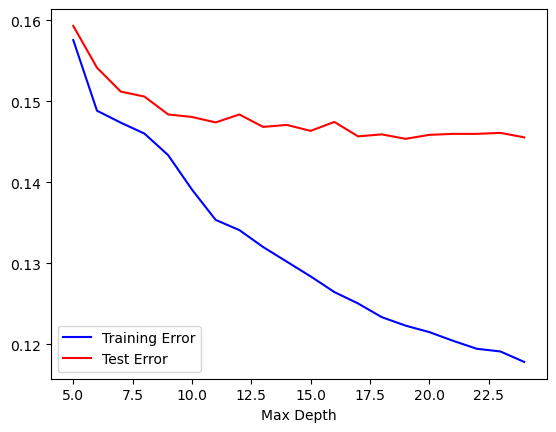

In [192]:
# try adjusting max_depth

training_error = []
test_error = []

for i in range(5,25):
    RFC = RandomForestClassifier(criterion="entropy",random_state=1234,max_depth=i,min_samples_split=50, min_samples_leaf=2)
    RFC.fit(reduced_adults_X, adults_y)

    adults_y_hat = RFC.predict(reduced_adults_X)
    adults_test_y_hat = RFC.predict (reduced_adults_test_X)
    training_error.append(J01(adults_y_hat, adults_y))
    test_error.append(J01(adults_test_y_hat, adults_test_y))
    
plt.plot([i for i in range(5,25)], training_error, color='blue')
plt.plot([i for i in range(5,25)], test_error, color="red")
plt.legend(["Training Error", "Test Error"], loc='lower left')
plt.xlabel("Max Depth")


In [193]:
for depth, error in zip([i for i in range(5,25)], test_error):
    print(f"Depth: {depth:2}, error: {error:.4}")



Depth:  5, error: 0.1593
Depth:  6, error: 0.1542
Depth:  7, error: 0.1512
Depth:  8, error: 0.1506
Depth:  9, error: 0.1484
Depth: 10, error: 0.1481
Depth: 11, error: 0.1474
Depth: 12, error: 0.1484
Depth: 13, error: 0.1469
Depth: 14, error: 0.1471
Depth: 15, error: 0.1464
Depth: 16, error: 0.1475
Depth: 17, error: 0.1457
Depth: 18, error: 0.1459
Depth: 19, error: 0.1454
Depth: 20, error: 0.1459
Depth: 21, error: 0.146
Depth: 22, error: 0.146
Depth: 23, error: 0.1461
Depth: 24, error: 0.1456


Text(0.5, 0, 'Max Samples')

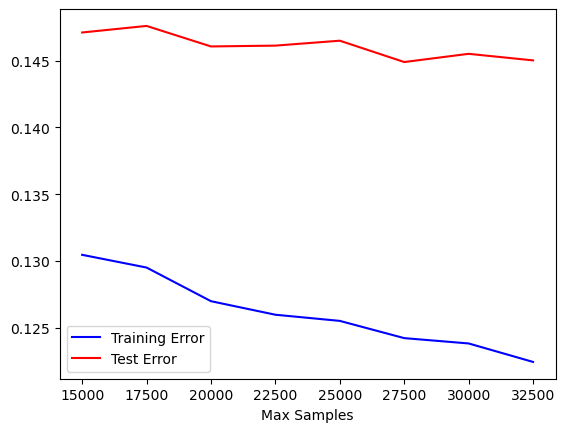

In [151]:
# max samples to use for each individual decision tree; default is the same amount as training data but may still be too much for overfitting

training_error = []
test_error = []

for i in range(15000, reduced_adults_X.shape[0], 2500):
    RFC = RandomForestClassifier(max_samples=i,criterion="entropy",random_state=1234,max_depth=19,min_samples_split=50, min_samples_leaf=2)
    RFC.fit(reduced_adults_X, adults_y)

    adults_y_hat = RFC.predict(reduced_adults_X)
    adults_test_y_hat = RFC.predict (reduced_adults_test_X)
    training_error.append(J01(adults_y_hat, adults_y))
    test_error.append(J01(adults_test_y_hat, adults_test_y))
    
plt.plot([i for i in range(15000, reduced_adults_X.shape[0], 2500)], training_error, color='blue')
plt.plot([i for i in range(15000, reduced_adults_X.shape[0], 2500)], test_error, color="red")
plt.legend(["Training Error", "Test Error"], loc='lower left')
plt.xlabel("Max Samples")


In [152]:
for max_samples, error in zip([i for i in range(15000, reduced_adults_X.shape[0], 2500)], test_error):
    print(f"Max Samples: {max_samples:2}, Test error: {error:.4}")


Max Samples: 15000, Test error: 0.1471
Max Samples: 17500, Test error: 0.1476
Max Samples: 20000, Test error: 0.1461
Max Samples: 22500, Test error: 0.1461
Max Samples: 25000, Test error: 0.1465
Max Samples: 27500, Test error: 0.1449
Max Samples: 30000, Test error: 0.1455
Max Samples: 32500, Test error: 0.145


## Best Classifier Thus Far

In [194]:
RFC = RandomForestClassifier(criterion="entropy",random_state=1234,min_samples_split=50, min_samples_leaf=2)
RFC.fit(reduced_adults_X, adults_y)
adults_y_hat = RFC.predict(reduced_adults_X)
adults_test_y_hat = RFC.predict (reduced_adults_test_X)
print("Training Error:",J01(adults_y_hat, adults_y))
print("Testing Error:", J01(adults_test_y_hat, adults_test_y))



Training Error: 0.11744111053100337
Testing Error: 0.14476997727412322
